In [1]:
using XFields
using FFTransforms
using LinearAlgebra
using PyPlot

Define the transform
------------------------------------------

In [2]:
Ft = let
    𝕨 = r𝕎32(128, π) ⊗ 𝕎(256, 4.0)
    ordinary_scale(𝕨)*𝕨
end;

Signal and noise spectral density
--------------------------------------------

Signal spectral density

In [3]:
Cf = let Ft = Ft, ρ = 0.5, ν = 0.1, σ² = 1/2
    l    = wavenum(Ft)
    d    = ndims(l)
    α    = √(2ν) / ρ
    cl   = @. hypot(α,l)^(-2ν-d)
    clop   = DiagOp(Xfourier(Ft, cl))
    cv0 = (clop[:] ./ (2π)^(d/2))[1]
    # cv0 ==  auto-cov at lag 0, i.e. the pixel space variance
    # Divide by cv0 so the variance is one, then mult by σ²

    clop * (σ² / cv0)
end;

Noise spectral density

In [4]:
Cn =  let Ft=Ft, μKarcminT=15, ℓknee=50, αknee=2

    Ωx_unit = deg2rad(1/60)^2 ## area [rad²] for 1arcmin×1arcmin pixel
    wvn     = wavenum(Ft); wvn[1] = Inf
    knee    = @. 1 + XFields.nan2zero((ℓknee / wvn) ^ αknee)
    cnl     = μKarcminT^2 .* Ωx_unit .* knee
    Cn      =  Xfourier(Ft, μKarcminT^2 .* Ωx_unit .* knee) |> DiagOp

    Cn
end;

Mask and Transfer function linear operators
--------------------------------------------

Mask

In [5]:
Ma =  let Ft=Ft, x1bdry = (0.1, 0.9), x2bdry = (0.2,0.95)

    lbr1, rbr1 = Ft.period[1] .* x1bdry
    lbr2, rbr2 = Ft.period[2] .* x2bdry
    x1, x2 = pix(Ft)
    ma = (lbr1 .< x1 .< rbr1) .* (lbr2 .< x2 .< rbr2)'
    Ma = Xmap(Ft, ma) |> DiagOp

    Ma
end;

Transfer function

In [6]:
Tr =  let Ft=Ft, beam_npix = 4

    fwhm_rad = beam_npix * min(Δpix(Ft)...)
    beam = l -> exp(-abs2(l * fwhm_rad) / (16*log(2)))
    tr   = beam.(wavenum(Ft))
    tr .*= wavenum(Ft) .< 0.9nyq(Ft)[1]
    Tr   = Xfourier(Ft, tr) |> DiagOp

    Tr
end;

White noise simulator
------------------------------------

In [7]:
function ωη(Ft::T) where T<:Transform
    zx = randn(eltype_in(Ft),size_in(Ft))
    Xmap(Ft, zx ./ √Ωx(Ft))
end

ωη (generic function with 1 method)

Field simulation: signal (`fsim`), noise (`nsim`) and data (`dsim`)
--------------------------------------------------------------

In [8]:
dsim, fsim, nsim = let Ft=Ft, Cf=Cf, Cn=Cn, Cf=Cf, Ma=Ma, Tr=Tr

    fsim = √Cf * ωη(Ft)
    nsim = √Cn * ωη(Ft)

    dsim = Ma * Tr * fsim + Ma * nsim
    μsim = Xmap(Ft,sum(dsim[:]) ./ sum(Ma[:]))

    dsim = dsim - Ma * μsim

    dsim, fsim, nsim
end;

Plots of the signal, noise and data
--------------------------------------------------------------

## Signal `fsim`

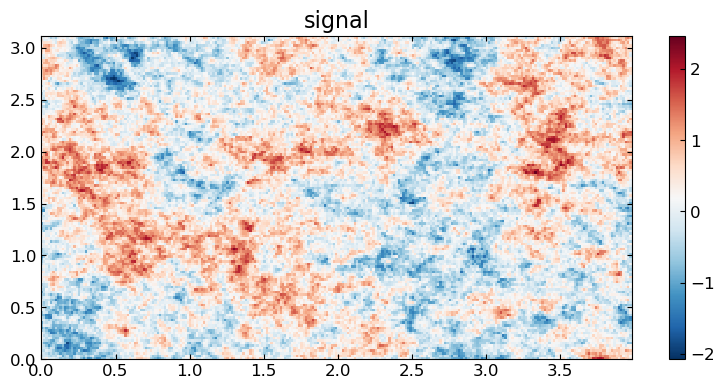

In [9]:
let Ft=Ft, f=fsim
    fig, ax = subplots(1, figsize=(8,4))
    x1, x2 = pix(Ft)
    pcm = ax.pcolormesh(x2, x1, f[:])
    ax.set_title("signal")
    fig.colorbar(pcm, ax = ax)
    fig.tight_layout()
end;
gcf()

## Noise `nsim`

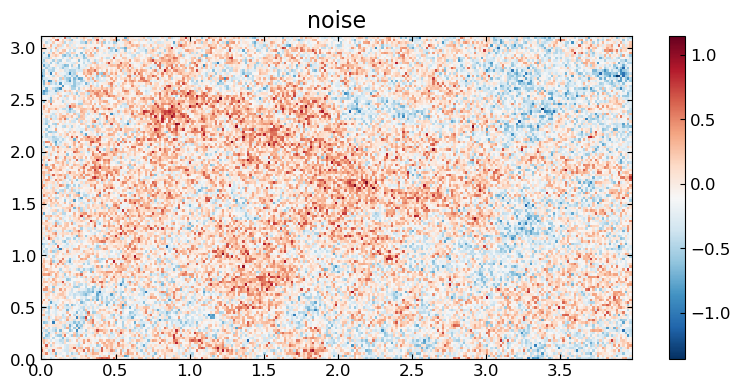

In [10]:
let Ft=Ft, f=nsim
    fig, ax = subplots(1, figsize=(8,4))
    x1, x2 = pix(Ft)
    pcm = ax.pcolormesh(x2, x1, f[:])
    ax.set_title("noise")
    fig.colorbar(pcm, ax = ax)
    fig.tight_layout()
end;
gcf()

## Data `dsim`

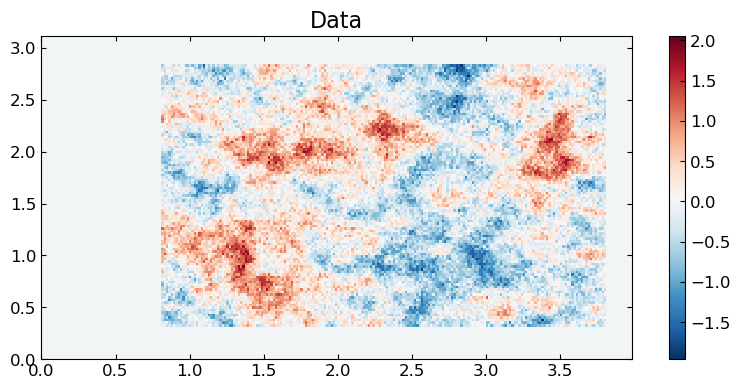

In [11]:
let Ft=Ft, f=dsim
    fig, ax = subplots(1, figsize=(8,4))
    x1, x2 = pix(Ft)
    pcm = ax.pcolormesh(x2, x1, f[:])
    ax.set_title("Data")
    fig.colorbar(pcm, ax = ax)
    fig.tight_layout()
end;
gcf()

## Mask and transfer

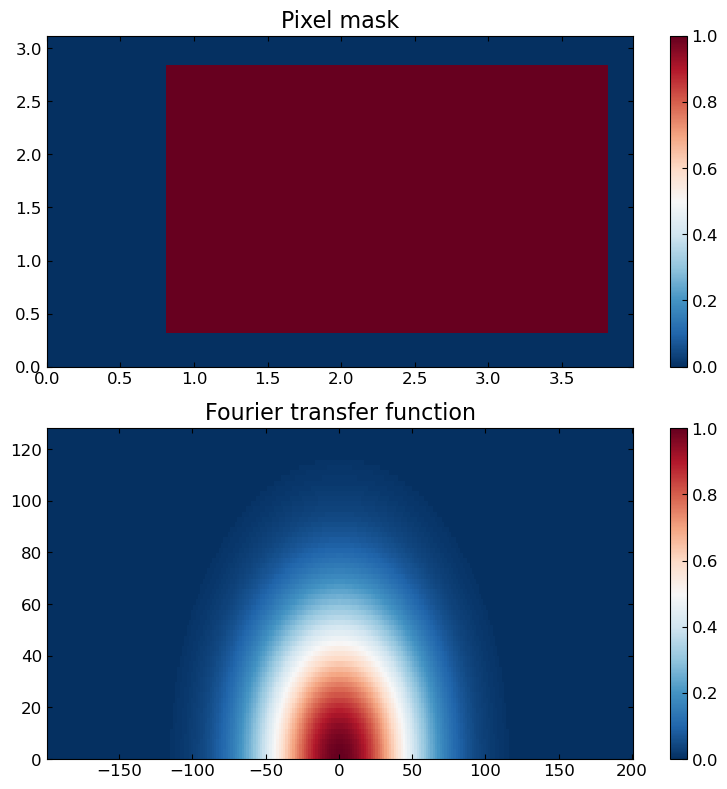

In [12]:
let Ft=Ft, Ma=Ma, Tr=Tr
    fig, ax = subplots(2,1, figsize=(8,8))

    x1, x2 = pix(Ft)
    pcm1 = ax[1].pcolormesh(x2, x1, Ma[:])
    ax[1].set_title("Pixel mask")

    l1, l2 = freq(Ft)
    p2 = sortperm(l2)
    tr = real.(Tr[!])
    pcm2 = ax[2].pcolormesh(l2[p2], l1, tr[:,p2])
    ax[2].set_title("Fourier transfer function")

    fig.colorbar(pcm1, ax=ax[1])
    fig.colorbar(pcm2, ax=ax[2])
    fig.tight_layout()
end;
gcf()

Bandpowers (i.e. periodogram)
--------------------------------------------------------------

In [13]:
function power(f::Xfield{F}, g::Xfield{F}; bin::Int=2, kmax=Inf, mult=1) where F<:Transform
    Ft     = fieldtransform(f)
    k      = wavenum(Ft)
    pwr    = @. mult * real(f[!] * conj(g[!]) + conj(f[!]) * g[!]) / 2
    Δbin   = bin * minimum(Δfreq(Ft))
    k_left = 0
    while k_left < min(kmax, maximum(k))
        k_right    = k_left + Δbin
        indx       = findall(k_left .< k .<= k_right)
        pwr[indx] .= sum( pwr[indx] ) / length( pwr[indx] )
        k_left  = k_right
    end
    return pwr
end

power (generic function with 1 method)

In [14]:
function power(f::Xfield{F}; bin::Int=2, kmax=Inf, mult=1) where F<:Transform
    power(f, f; bin=bin, kmax=kmax, mult=mult)
end

power (generic function with 2 methods)

## Noise and signal bandpowers

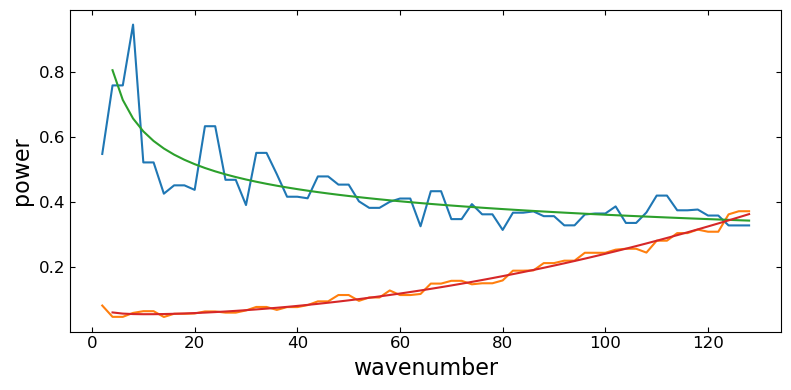

In [15]:
let Ft=Ft, Cn=Cn, Cf=Cf, f=fsim, n=nsim
    l     = wavenum(Ft)
    mult  = l .* (l .+ 1)

    fig, ax = subplots(1, figsize=(8,4))

    pwrf = power(f; mult=mult * Ωk(Ft) )
    pwrn = power(n; mult=mult * Ωk(Ft) )
    (l[:,1], pwrf[:,1]) |> x->ax.plot(x[1][2:end],x[2][2:end])
    (l[:,1], pwrn[:,1]) |> x->ax.plot(x[1][2:end],x[2][2:end])

    cf = real.(Cf[!])
    cn = real.(Cn[!])
    (l[:,1], (mult.*cf)[:,1]) |> x->ax.plot(x[1][3:end],x[2][3:end])
    (l[:,1], (mult.*cn)[:,1]) |> x->ax.plot(x[1][3:end],x[2][3:end])

    ax.set_xlabel("wavenumber")
    ax.set_ylabel("power")
    fig.tight_layout()
end;
gcf()

Set up basic  d = M⋅Tf⋅f + M⋅n
--------------------------------------------------------------

custom pcg with function composition (Minv * A \approx I)

In [16]:
function pcg(Minv::Function, A::Function, b, x=0*b; nsteps::Int=75, rel_tol::Float64 = 1e-8)
    r       = b - A(x)
    z       = Minv(r)
    p       = deepcopy(z)
    res     = dot(r,z)
    reshist = Vector{typeof(res)}()
    for i = 1:nsteps
        Ap        = A(p)
        α         = res / dot(p,Ap)
        x         = x + α * p
        r         = r - α * Ap
        z         = Minv(r)
        res′      = dot(r,z)
        p         = z + (res′ / res) * p
        rel_error = XFields.nan2zero(sqrt(dot(r,r)/dot(b,b)))
        if rel_error < rel_tol
            return x, reshist
        end
        push!(reshist, rel_error)
        res = res′
    end
    return x, reshist
end

pcg (generic function with 2 methods)

In [17]:
function LinearAlgebra.dot(f::Xfield{FT},g::Xfield{FT}) where FT<:Transform
    Ft = fieldtransform(f)
    Ωx(Ft) * dot(f[:],g[:])
end

In [18]:
wfsim, wfhist, zwf = let Ft=Ft, Cn=Cn, Cf=Cf, Tr=Tr, Ma=Ma, dsim=dsim

    A  = Ma * Tr / Cn * Tr * Ma
    B  = 1 / Cf
    P  = Tr / Cn * Tr + B

    wfsim, wfhist = pcg(
            w -> P * w,
            w -> A * w +  B * w,
            Ma * Tr / Cn * dsim,
            nsteps  = 500,
            rel_tol = 1e-15,
    )

    # compte the chi2 z-score
    dfd   = sum(Ma[:]) # degrees of freedom of the data
    Δ1    = dsim - Ma * wfsim
    zwf  = - dot(Δ1, Cn \ Δ1) - dot(wfsim, Cf \ wfsim)
    zwf -= -dfd
    zwf /= sqrt(2*dfd)


    wfsim, wfhist, zwf

end;

In [19]:
zwf

9.468261602083029

the "residual" per iteration

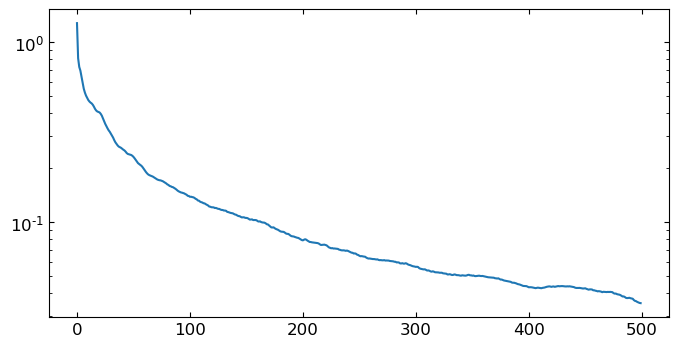

In [20]:
let wfhist=wfhist
    fig, ax = subplots(1, figsize=(8,4))
    semilogy(wfhist)
end;
gcf()

The Wiener filter

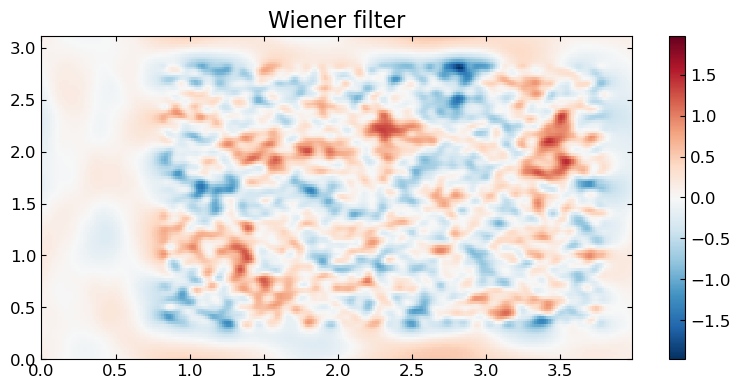

In [21]:
let Ft=Ft, f=wfsim
    fig, ax = subplots(1, figsize=(8,4))
    x1, x2 = pix(Ft)
    vm = extrema(f[:]) .|> abs |> x->max(x...)
    pcm = ax.pcolormesh(x2, x1, f[:],vmin=-vm, vmax=vm)
    ax.set_title("Wiener filter")
    fig.colorbar(pcm, ax = ax)
    fig.tight_layout()
end;
gcf()

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*